# Homework 8

**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, March 30th, 2018 at 11:00am

**Instructions:**

- Upload your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Name: Christopher Hase

In [66]:
import numpy as np
import pymc3 as pm
from pymc3 import summary, sample_ppc, find_MAP, traceplot
import pandas as pd
from matplotlib import pyplot as plt




## Problem 1: Understanding Yelp Review Data As a Human
In this course, we've spent a lot of time learning algorithms for performing inference on complex models and we've spent time using these models to make decisions regarding our data. But in nearly every assignment, the model for the data is specified in the problem statement. In real life, the creative and, arguably, much more difficult task is to start with a broadly defined goal and then to customize or create a model which will meet this goal in some way. 



Problem #1 is atypical in that it does not involve any programming or (necessarily) difficult mathematics/statistics. The process of answering these questions *seriously* will however give you an idea of how one might create or select a model for a particular application and your answers will help you with formalizing the model if and when you're called upon to do so.

***Grading:*** *We want you to make a genuine effort to mold an ambiguous and broad real-life question into a concrete data science or machine learning problem without the pressure of getting the "right answer". As such, we will grade your answer of Problem #1 on a pass/fail basis. Any reasonable answer that demonstrates actual effort will be given a full grade.*

We've compiled for you a fairly representative selection of [Yelp reviews](./yelp_reviews.zip) for a (now closed) sushi restaurant called Ino's Sushi in San Francisco. Read the reviews and form an opinion regarding the various qualities of Ino's Sushi. Answer the following:

1. If the task is to summarize the quality of a restaurant in a simple and intuitive way, what might be problematic with simply classifying this restaurant as simply "good" or "bad"? Justify your answers with specific examples from the dataset.

2. For Ino's Sushi, categorize the food and the service, separately, as "good" or "bad" based on all the reviews in the dataset. Be as systematic as you can when you do this.

  (**Hint:** Begin by summarizing each review. For each review, summarize the reviewer's opinion on two aspects of the restaurant: food and service. That is, generate a classification ("good" or "bad") for each aspect based on what the reviewer writes.) 
  
3. Identify statistical weaknesses in breaking each review down into an opinion on the food and an opinion on the service. That is, identify types of reviews that make your method of summarizing the reviewer's optinion on the quality of food and service problemmatic, if not impossible. Use examples from your dataset to support your argument. 

4. Identify all the ways in which the task in #2 might be difficult for a machine to accomplish. That is, break down the classification task into simple self-contained subtasks and identify how each subtask can be accomplished by a machine (i.e. which area of machine learning, e.g. topic modeling, sentiment analysis etc, addressess this type of task).

5. Describe a complete pipeline for processing and transforming the data to obtain a classification for both food and service for each review.

## Problem 2: My Sister-In-Law's Baby Cousin Tracy ...


Wikipedia describes the National Annenberg Election Survey as follows -- "National Annenberg Election Survey (NAES) is the largest academic public opinion survey conducted during the American presidential elections. It is conducted by the Annenberg Public Policy Center at the University of Pennsylvania."  In the file [survey.csv](./survey.csv) we provide the following data from the 2004 National Annenberg Election Survey:  `age` -- the age of the respondents, `numr` -- the number of responses, and `knowlgbtq` -- the number of people at the given age who have at least one LGBTQ acquaintance.  We want you to model how age influences likelihood of interaction with members of the LGBTQ community in two ways. 


1. Using pymc3, create a bayesian regression model (either construct the model directly or use the glm module) with the same feature and dependent variable. Plot the mean predictions for ages 0-100, with a 2-sigma envelope.

2. Using pymc3, create a 1-D Gaussian Process regression model with the same feature and dependent variables.  Use a squared exponential covariance function. Plot the mean predictions for ages 0-100, with a 2-sigma envelope.

3. How do the models compare? Does age influence likelihood of acquaintance with someone LGBTQ? For Bayesian Linear Regression and GP Regression, how does age affect the variance of the estimates?

For GP Regression, we can model the likelihood of knowing someone LGBTQ as a product of binomials -- one binomial distribution per age group. 

$$p(y_a | \theta_a, n_a) = Binom( y_a, n_a, \theta_a)$$

where $y_a$ (i.e. `knowlgbtq`) is the observed number of respondents who know someone lgbtq  at age $a$, $n_a$ (i.e. `numr`) is the number of trials and $\theta_a$ is the rate parameter for having an lgbtq acquaintance at age $a$.

Using the Gaussian approximation  (http://en.wikipedia.org/wiki/Binomial_distribution#Normal_approximation) to approximate the Binomial since `numr` is large, you can simply use a GP posterior with the error for each measurement to be given using this approximation. 

In [34]:
# read in data
survey = pd.read_csv('survey.csv')

# add ratio variable
survey['ratio'] = pd.Series(survey['knowlgbtq']/survey['numr'])

survey.head()

,age,numr,knowlgbtq,ratio
0,18,310,158,0.509677
1,19,221,118,0.533937
2,20,217,120,0.552995
3,21,255,131,0.513725
4,22,301,168,0.558140


### Part 1

In [119]:
# bayesian linear regression
# modeling proportion of those who know lgbtq using age
with pm.Model() as bayes_reg:
    
    priors = {'Intercept': pm.Normal.dist(mu=0, sd=10),
              'age': pm.Normal.dist(mu=0, sd=10)}
    
    pm.glm.GLM.from_formula('ratio ~ age', survey, family = pm.glm.families.Normal(), priors = priors)
    
    step = pm.step_methods.hmc.nuts.NUTS()
    
    bayes_reg_trace = pm.sampling.sample(draws = 20000, step = step, init = 'advi', 
                                         compute_convergence_checks = True, chains = 2, tuning = 3000)

Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, age, Intercept]
100%|██████████| 20500/20500 [01:48<00:00, 188.22it/s]


In [117]:
# sampling from posterior predictive of bayesian regression model
with bayes_reg:
    bayes_post_pred = sample_ppc(bayes_reg_trace[1000::10], samples=1000)

100%|██████████| 1000/1000 [00:02<00:00, 485.94it/s]


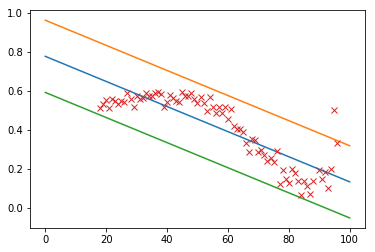

In [121]:
# plotting predictions and confidence bands for bayesian regression model
trace_summary = summary(bayes_reg_trace[1000::10])
intercept = trace_summary['mean'][0]
age_coef = trace_summary['mean'][1]
sd = trace_summary['mean'][2]

pred_mean_ratios = np.zeros(101)
ratio_upper = np.zeros(101)
ratio_lower = np.zeros(101)

for i in range(101):
    pred_mean_ratios[i] = intercept + age_coef * i
    ratio_upper[i] = intercept + age_coef * i + 2 * sd
    ratio_lower[i] = intercept + age_coef * i - 2 * sd
    
plt.plot(np.arange(101), pred_mean_ratios)
plt.plot(np.arange(101), ratio_upper)
plt.plot(np.arange(101), ratio_lower)
plt.plot(survey['age'], survey['ratio'], 'x')
plt.plot()
plt.show()

### Part 2

In [18]:
# gaussian process model
# modeling proportion of those who know lgbtq using age
with pm.Model() as gp_reg:

    length = pm.HalfCauchy('length', 1)
    sigma = pm.HalfCauchy('sigma', 1)
    
    M = pm.gp.mean.Linear(coeffs=np.mean(survey['ratio'].values))
    K = (sigma**2) * pm.gp.cov.ExpQuad(1, length) 
    
    noise_term = pm.HalfCauchy('noise_term', 1)
    
    rate_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    obs_rate = rate_gp.marginal_likelihood('ratio', X=survey['age'].values.reshape(-1,1),
                                           y=survey['ratio'].values,
                                           noise=noise_term)

In [21]:
with gp_reg:
    step = pm.step_methods.hmc.nuts.NUTS()
    gp_trace = pm.sampling.sample(draws = 50000, step = step,\
                               init = 'advi', compute_convergence_checks = True, chains = 2)

Sequential sampling (2 chains in 1 job)
NUTS: [noise_term_log__, sigma_log__, length_log__]
100%|██████████| 50500/50500 [11:54<00:00, 70.72it/s]
The acceptance probability does not match the target. It is 0.898664780506, but should be close to 0.8. Try to increase the number of tuning steps.


In [24]:
# sampling from posterior predictive of GP model
with gp_reg:
    gp_post_pred = sample_ppc(gp_trace[1000::10], samples=1000)

100%|██████████| 1000/1000 [00:05<00:00, 182.53it/s]


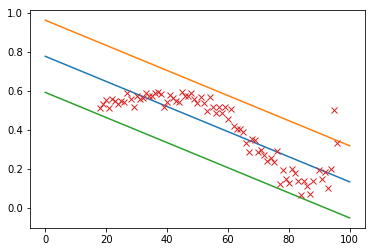

In [39]:
# plotting predictions and confidence bands for GP model
trace_summary = summary(gp_trace[1000::10])
intercept = trace_summary['mean'][0]
age_coef = trace_summary['mean'][1]
sd = trace_summary['mean'][2]

pred_mean_ratios = np.zeros(101)
ratio_upper = np.zeros(101)
ratio_lower = np.zeros(101)

for i in range(101):
    pred_mean_ratios[i] = intercept + age_coef * i
    ratio_upper[i] = intercept + age_coef * i + 2 * sd
    ratio_lower[i] = intercept + age_coef * i - 2 * sd
    
plt.plot(np.arange(101), pred_mean_ratios)
plt.plot(np.arange(101), ratio_upper)
plt.plot(np.arange(101), ratio_lower)
plt.plot(survey['age'], survey['ratio'], 'x')
plt.plot()
plt.show()

### Part 3

## Problem 3:  Like a Punch to the Kidneys 

In this problem we will work with the US Kidney Cancer Dataset (by county), a dataset of kidney cancer frequencies across the US over 5 years on a per county basis. 

The kidney cancer data can be found [here](./kcancer.csv).

A casual inspection of the data might suggest that we independently model cancer rates for each of the provided counties.  Our experience in past homeworks/labs/lectures (in particular when we delved into the Rat Tumors problem) suggests potential drawbacks of conclusions based on raw cancer rates.  Addressing these drawbacks, let's look use a Bayesian model for our analysis of the data. In particular you will implement an Empircal Bayes model to examine the adjusted cancer rates per county.

Let $N$ be the number of counties; let $y_j$ the number of kidney cancer case for the $j$-th county, $n_j$ the population of the $j$-th county and $\theta_j$ the underlying kidney cancer rate for that county. We can construct a Bayesian model for our data as follows:
\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N
\end{aligned}
where $\alpha, \beta$ are hyper-parameters of the model.

- (#1) Implement Empirical Bayes via moment matching as described as follows. Consider the **prior-predictive** distribution (also called the evidence i.e. the denominator normalization in bayes theorem) of the model: $p(y) = \int p(y \vert \theta) p(\theta) d \theta$. Why the prior-predictive? Because technically we "haven't seen" individual county data yet.  For this model, the prior-predictive is a negative binomial. Matching the mean and the variance of the negative binomial to that from the data, you can find appropriate expressions for $\alpha$ and $\beta$. (Hint: You need to be careful with the $5n_j$ multiplier.) 

- (#2) Produce a scatter plot of the raw cancer rates (pct mortality) vs the county population size. Highlight the top 300 raw cancer rates in red. Highlight the bottom 300 raw cancer rates in blue. Finally, on the same plot add a scatter plot visualization of the posterior mean cancer rate estimates (pct mortality) vs the county population size, highlight these in green.

- (#3) Using the above scatter plot, explain why using the posterior means from our model to estimate cancer rates is preferable to studying the raw rates themselves.

(**Hint:** You might also find it helpful to follow the Rat Tumor example.)

(**Note:** Up until now we've had primarily thought about the posterior predictive: $\int p( y \vert \theta) p(\theta \vert D) d\theta$.  The posterior predictive and the prior predictive can be somewhat connected. In conjugate models such as ours, the two distributions have the same form.) 

## Problem 4: In the Blink of a Bayesian Iris

We've done classification before, but the goal of this problem is to introduce you to the idea of classification using Bayesian inference. 

Consider the famous *Fisher flower Iris data set* a  multivariate data set introduced by Sir Ronald Fisher (1936) as an example of discriminant analysis. The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. Based on the combination of these four features, you will build a model to predict the species. 

For this problem only consider two classes: **virginica** and **not-virginica**. 

The iris data can be obtained [here](./iris.csv).

Let $(X, Y )$ be our dataset, where $X=\{\vec{x}_1, \ldots \vec{x}_n\}$ and $\vec{x}_i$ is the standard feature vector corresponding to an offset 1 and the four components explained above. $Y \in \{0,1\}$ are the scalar labels of a class. In other words the species labels are your $Y$ data (virginica = 0 and virginica=1), and the four features -- petal length, petal width, sepal length and sepal width -- along with the offset make up your $X$ data. 

The goal is to train a classifier, that will predict an unknown class label $\hat{y}$ from a new data point $x$. 

Consider the following glm (logistic model) for the probability of a class:

$$ p(y) = \frac{1}{1+e^{-x^T \beta}} $$

(or $logit(p) = x^T \beta$ in more traditional glm form)

where $\beta$ is a 5D parameter to learn. 

Then given $p$ at a particular data point $x$, we can use a bernoulli likelihood to get 1's and 0's. This should be enough for you to set up your model in pymc3. (Other Hints: also use theano.tensor.exp when you define the inverse logit to go from $\beta$ to $p$, and you might want to set up $p$ as a deterministic explicitly so that pymc3 does the work of giving you the trace).

Use a 60-40 stratified (preserving class membership) split of the dataset into a training set and a test set. (Feel free to take advantage of scikit-learn's `train_test_split`).

1. Choose a prior for $\beta \sim N(0, \sigma^2 I) $ and write down the formula for the normalized posterior $p(\beta| Y,X)$. Since we dont care about regularization here, just use the mostly uninformative value $\sigma = 10$.
2. Find the MAP and mean estimate for the posterior on the training set.
3. Implement a  sampler to sample from this posterior of $\beta$.   Generate samples of $\beta$ and plot the sequence of $\beta$'s  and histograms for each $\beta$ component.

### Part 1

$p(\beta|X,Y)=\dfrac{p(Y|X,\beta)\cdot p(\beta)}{\int p(Y|X,\beta)\cdot p(\beta)\cdot d\beta}=\dfrac{\displaystyle\prod_{i=1}^n\bigg(\dfrac{1}{1+\exp(-x_i^T\beta)}\bigg)^{y_i}\cdot \bigg(\dfrac{\exp(-x_i^T\beta)}{1+\exp(-x_i^T\beta)}\bigg)^{1-y_i}\cdot N(\beta|0,100I)}{\displaystyle\int\displaystyle\prod_{i=1}^n\bigg(\dfrac{1}{1+\exp(-x_i^T\beta)}\bigg)^{y_i}\cdot \bigg(\dfrac{\exp(-x_i^T\beta)}{1+\exp(-x_i^T\beta)}\bigg)^{1-y_i}\cdot N(\beta|0,100I)\cdot d\beta}$

### Part 2

In [41]:
# read in data, format, and view
iris = pd.read_csv('iris.csv')
iris = pd.get_dummies(iris).iloc[:, [0,1,2,3,6]]
iris.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'virginica']
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,virginica
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [104]:
# bayesian logit
with pm.Model() as bayes_logit:
    
    priors = {'Intercept': pm.Normal.dist(mu=0, sd=10),
              'sepal_length': pm.Normal.dist(mu=0, sd = 10),
              'sepal_width': pm.Normal.dist(mu=0, sd = 10),
              'petal_length': pm.Normal.dist(mu=0, sd = 10),
              'petal_width': pm.Normal.dist(mu=0, sd = 10)}
    
    pm.glm.GLM.from_formula('virginica ~ sepal_length + sepal_width + petal_length + petal_width', 
                            iris, family = pm.glm.families.Binomial(), priors = priors)
    
    step = pm.step_methods.hmc.nuts.NUTS()
    
    bayes_logit_trace = pm.sampling.sample(draws = 20000, step = step, init = 'advi',
                                           compute_convergence_checks = False, chains = 1, target_accept = 0.95)

Sequential sampling (1 chains in 1 job)
NUTS: [petal_width, petal_length, sepal_width, sepal_length, Intercept]
100%|██████████| 5500/5500 [03:52<00:00, 23.61it/s]
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [108]:
map_estimate = find_MAP(model=bayes_logit)
posterior_df = pd.DataFrame(map_estimate, index = np.arange(1)).transpose()
posterior_df['Posterior Mean'] = pd.Series(summary(bayes_logit_trace[100::10])['mean'])
posterior_df.columns = ['MAP', 'Posterior Mean']
posterior_df

logp = -25.2, ||grad|| = 0.00040787: 100%|██████████| 34/34 [00:00<00:00, 835.60it/s]  


,MAP,Posterior Mean
Intercept,-13.253616,-15.913102
petal_length,6.119178,8.228457
petal_width,9.523940,11.120635
sepal_length,-3.249386,-4.510340
sepal_width,-4.355425,-5.232853


### Part 3

Note that the sampler was implemented in part 2 to get estimate the posterior mean for $\beta$.

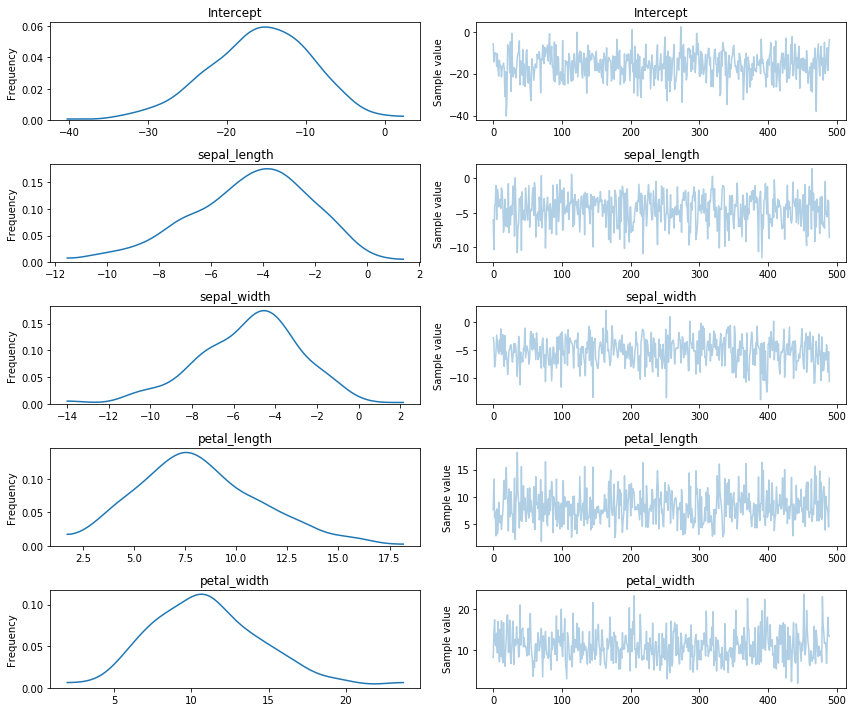

In [107]:
# traceplot and empirical posterior pdf for each component of beta
traceplot(bayes_logit_trace[100::10])
plt.show()

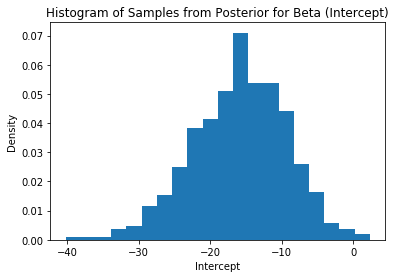

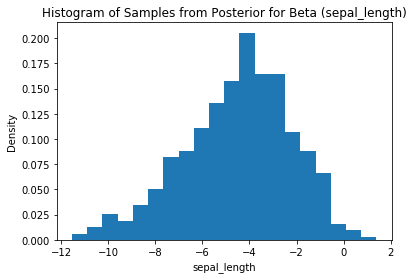

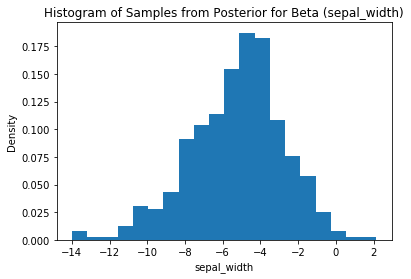

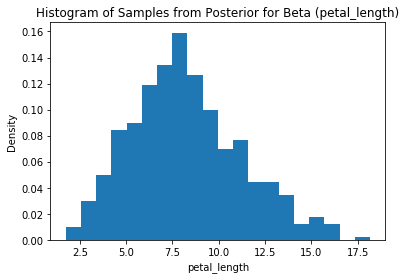

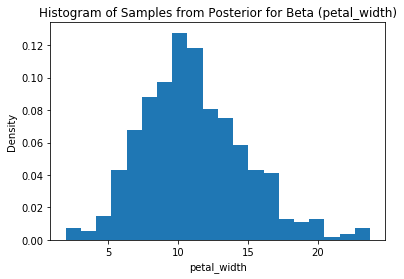

In [110]:
# plotting histograms of samples from posterior of beta for each component
plt.hist(bayes_logit_trace[100::10]['Intercept'], bins = 20, density = True)
plt.title('Histogram of Samples from Posterior for Beta (Intercept)')
plt.xlabel('Intercept')
plt.ylabel('Density')
plt.show()

plt.hist(bayes_logit_trace[100::10]['sepal_length'], bins = 20, density = True)
plt.title('Histogram of Samples from Posterior for Beta (sepal_length)')
plt.xlabel('sepal_length')
plt.ylabel('Density')
plt.show()

plt.hist(bayes_logit_trace[100::10]['sepal_width'], bins = 20, density = True)
plt.title('Histogram of Samples from Posterior for Beta (sepal_width)')
plt.xlabel('sepal_width')
plt.ylabel('Density')
plt.show()

plt.hist(bayes_logit_trace[100::10]['petal_length'], bins = 20, density = True)
plt.title('Histogram of Samples from Posterior for Beta (petal_length)')
plt.xlabel('petal_length')
plt.ylabel('Density')
plt.show()

plt.hist(bayes_logit_trace[100::10]['petal_width'], bins = 20, density = True)
plt.title('Histogram of Samples from Posterior for Beta (petal_width)')
plt.xlabel('petal_width')
plt.ylabel('Density')
plt.show()